In [1]:
from PIL import Image
import random
import math
import time
from IPython.display import display
from IPython.display import clear_output
from PIL import Image, ImageDraw , ImageFont

im_size = (240,240)
pastelColorPallet = [(27,133,184),(90,82,85),(85,158,131),(174,90,65),(195,203,113),(249,107,75),(249,167,143),(195,155,211),(161,126,111)]


In [2]:

def rotPnt(pnt,ang):
    rotY = getYrot(ang[1]) 
    rotX = getXrot(ang[0])
    rot_a = transformVec(rotY[0],rotY[1],rotY[2],rotX[0])
    rot_b = transformVec(rotY[0],rotY[1],rotY[2],rotX[1])
    rot_c = transformVec(rotY[0],rotY[1],rotY[2],rotX[2])
    pnt_out = transformVec(rot_a,rot_b,rot_c,pnt)
    return pnt_out
    
def getYrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (math.cos(ang),0.0,math.sin(ang))
    yhat = (0.0,1.0,0.0)
    zhat = (-math.sin(ang),0.0,math.cos(ang))
    return (xhat,yhat,zhat)
    
def getXrot(ang_d):
    ang = math.radians(ang_d)
    xhat = (1.0,0.0,0.0)
    yhat = (0.0,math.cos(ang),-math.sin(ang))
    zhat = (0.0,math.sin(ang),math.cos(ang))
    return (xhat,yhat,zhat)

def rotcamPnt(pnt,ang):
    rotY = getYrot(-ang[1]) 
    rotX = getXrot(-ang[0])
    rot_a = transformVec(rotX[0],rotX[1],rotX[2],rotY[0])
    rot_b = transformVec(rotX[0],rotX[1],rotX[2],rotY[1])
    rot_c = transformVec(rotX[0],rotX[1],rotX[2],rotY[2])
    pnt_out = transformVec(rot_a,rot_b,rot_c,pnt)
    return pnt_out

def transformVec(xhat,yhat,zhat,pnt):
    out_x = xhat[0]*pnt[0]+yhat[0]*pnt[1]+zhat[0]*pnt[2]
    out_y = xhat[1]*pnt[0]+yhat[1]*pnt[1]+zhat[1]*pnt[2]
    out_z = xhat[2]*pnt[0]+yhat[2]*pnt[1]+zhat[2]*pnt[2]
    #print((out_x,out_y,out_z))
    return (out_x,out_y,out_z)
    
def dot_2d(a,b):
    return (a[0]*b[0] + a[1]*b[1])

def dot_3d(a,b):
    return (a[0]*b[0] + a[1]*b[1]+ a[2]*b[2])

def cross_3d(a,b):
    return (a[1]*b[2]-a[2]*b[1],-(a[0]*b[2]-a[2]*b[0]),a[0]*b[1]-a[1]*b[0])
    
def getperpendicular_clock(a):
    return (a[1],-a[0])

def posPnt(pnt,pos):
    return((pnt[0]+pos[0],pnt[1]+pos[1],pnt[2]+pos[2]))

def verticeToScreen(vertice,ang,pos,screen_size,cam_ang = (0,0)):
    pnt = rotPnt(vertice,ang)
    pnt = posPnt(pnt,pos)
    pnt = rotcamPnt(pnt,cam_ang)
    FOV = math.radians(60)
    screenHeightWorld = math.tan(FOV/2)*2
    if pnt[2] <= 0:
        return None
    pixelsPerUnitWorld = screen_size[1]/screenHeightWorld/pnt[2]
    pixelOffset = (pnt[0]*pixelsPerUnitWorld,pnt[1]*pixelsPerUnitWorld)

    
    return ((screen_size[0]/2)+pixelOffset[0],(screen_size[1]/2)+pixelOffset[1])

def getlineX(strt_pnt,slope,y):
    x0,y0 = strt_pnt
    if slope == 0:
        return x0 
    elif slope == math.inf:
        return x0
    else:
        return int(((y-y0)/slope)+x0)

def transformColor(Color,ilumi):
    newColor = []
    for i in range(3):
        col = int(Color[i]*(ilumi-0.5))
        if col > 255:
            col = 255
        elif col < 0:
            col = 0
        newColor.append(col)
    #print(Color,' -> ',newColor)
    return tuple(newColor)
    
def PointsDistance3d(a,b):
    return math.sqrt( (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 )
    
class line_2d():
    def __init__(self,a,b):
        self.a = a
        self.b = b
        
    def isPointOnRightSide(self,pnt):
        ap = (pnt[0]-self.a[0],pnt[1]-self.a[1])
        ab_perp = getperpendicular_clock((self.b[0]-self.a[0],self.b[1]-self.a[1]))
        return (Dot_2d(ap,ab_perp) >= 0)

    def getSlope(self):
        subx = (self.a[0] - self.b[0])
        if subx == 0:
            return math.inf
        return (self.a[1] - self.b[1])/subx
    
class triangle_2d():
    def __init__(self,a,b,c,color = (255, 255, 255),lumination=0):
        stdpnts = sorted([a,b,c], key=lambda tup: tup[1])
        #print(stdpnts)
        self.a = (int(stdpnts[0][0]),int(stdpnts[0][1]))
        self.b = (int(stdpnts[1][0]),int(stdpnts[1][1]))
        self.c = (int(stdpnts[2][0]),int(stdpnts[2][1]))
        self.ab = line_2d(self.a,self.b)
        self.bc = line_2d(self.b,self.c)
        self.ca = line_2d(self.c,self.a)
        self.ab_slope = self.ab.getSlope()
        self.bc_slope = self.bc.getSlope()
        self.ca_slope = self.ca.getSlope()
        self.color = color
        
    def triangleArea(self):
        ac = (self.c[0]-self.a[0],self.c[1]-self.a[1])
        ab_perp = getperpendicular_clock((self.b[0]-self.a[0],self.b[1]-self.a[1]))
        return dot_2d(ac,ab_perp)
        
    def pointInTriangle(self,pnt):        
        max_x = max(self.a[0],self.b[0],self.c[0])
        max_y = max(self.a[1],self.b[1],self.c[1])
        min_x = min(self.a[0],self.b[0],self.c[0])
        min_y = min(self.a[1],self.b[1],self.c[1])
        if pnt[0] < max_x and pnt[0]> min_x:
            if pnt[1] < max_y and pnt[1]> min_y:
                check_ab = self.ab.isPointOnRightSide(pnt)
                check_bc = self.bc.isPointOnRightSide(pnt)
                check_ca = self.ca.isPointOnRightSide(pnt)
                return (check_ab and check_bc and check_ca)
        return False

    def half_render(self,ystart,ystop,pnt0,pnt1,slope0,slope1,im,wireframe=False):
        for y in range(int(ystart),int(ystop)):
            x0 = getlineX(pnt0,slope0,y)
            x1 = getlineX(pnt1,slope1,y)             
            x0 = max(min(x0, im_size[0]-1), 0)
            x1 = max(min(x1, im_size[0]-1), 0)
            y = max(min(y, im_size[1]-1), 0)
            #print(x0,x1)
            #print(slope0,' ',x0) 
            x_pnts = sorted([x0,x1])
            if wireframe:
                im.putpixel((x_pnts[0],y), self.color)
                im.putpixel((x_pnts[1],y), self.color)
            else:
                for x in range(x_pnts[0],x_pnts[1]):
                    #print(x,y)
                    im.putpixel((x,y), self.color)
                    
    def render(self,im):
        #print(self.triangleArea()," ",self.a,self.b,self.c)
        self.half_render(self.a[1],self.b[1],self.a,self.a,self.ab_slope,self.ca_slope,im)
        self.half_render(self.b[1],self.c[1],self.b,self.a,self.bc_slope,self.ca_slope,im)

class triangle_3d():
    def __init__(self,a,b,c,ang,pos,color = (255, 255, 255) ):
        self.a = a
        self.b = b
        self.c = c
        self.color = color
        self.ang = ang
        self.pos = pos

    def facingVectorCheck(self,camNormal):
        dot = dot_3d(self.getNormal(),camNormal) 
        #print(self.getNormal(),' ',dot)
        return (dot> 0)
        
    def getNormal(self):
        a,b,c = self.getUpdatedVertices()
        ac = (c[0]-a[0],c[1]-a[1],c[2]-a[2])
        ab = (b[0]-a[0],b[1]-a[1],b[2]-a[2])
        cross = cross_3d(ac,ab)
        crosslen = math.sqrt(cross[0]**2+cross[1]**2+cross[2]**2)
        normal = (cross[0]/crosslen,cross[1]/crosslen,cross[2]/crosslen)
        return normal
        
    def getClosestdistance(self,pnt):
        distances = []
        for v in [self.a,self.b,self.c]:
            distances.append(PointsDistance3d(v,pnt))
        return min(distances)
        
    def getCentroid(self):
        cx = (self.a[0]+self.b[0]+self.c[0])/3
        cy = (self.a[1]+self.b[1]+self.c[1])/3
        cz = (self.a[2]+self.b[2]+self.c[2])/3
        return((cx,cy,cz))
    
    def getDistanceToCentroid(self,pnt):
        c = self.getCentroid()
        #print(c)
        c = rotPnt(c,self.ang)
        c = posPnt(c,self.pos)
        return PointsDistance3d(c,pnt)
        
    def trig_3dToTrig_2d(self,cam_ang):
        a_ = verticeToScreen(self.a,self.ang,self.pos,im_size,cam_ang = cam_ang)
        b_ = verticeToScreen(self.b,self.ang,self.pos,im_size,cam_ang = cam_ang)
        c_ = verticeToScreen(self.c,self.ang,self.pos,im_size,cam_ang = cam_ang)
        if a_ == None or b_ == None or c_ == None:
            return None
        lightdirection = (0,0.8,0.2)
        global_ilumi = 0.7
        ilumi = dot_3d(lightdirection,self.getNormal())
        ilumi += global_ilumi
        if ilumi < 1:
            ilumi = 1 +ilumi
        if ilumi > 1.5:
            ilumi = 1.5
        newColor = transformColor(self.color,ilumi)
        return triangle_2d(a_,b_,c_,color=newColor)
    
    def getUpdatedVertices(self):
        a = rotPnt(self.a,self.ang)
        a = posPnt(a,self.pos)
        b = rotPnt(self.b,self.ang)
        b = posPnt(b,self.pos)
        c = rotPnt(self.c,self.ang)
        c = posPnt(c,self.pos)
        return (a,b,c)
    
    def update(self,ang,pos):
        self.pos = pos
        self.ang = ang
        
    def render(self,im,cam_ang=(0,0)):
        #self.trig_3dToTrig_2d().render_old(im)
        tri_2d = self.trig_3dToTrig_2d(cam_ang = cam_ang)
        if tri_2d != None:
            tri_2d.render(im)
        
class model():
    def __init__(self,vertices,faces,tri_indexes,pos=(0,0,0),ang=(0,0),updateVertices = False):
        self.vertices = vertices
        self.faces = faces
        self.tri_indexes = tri_indexes
        self.ang = ang
        self.pos = pos
        self.colorPallet = pastelColorPallet
        self.triangles = []
        self.updateTriangles(updateVertices=updateVertices)

    def updateTriangles(self,updateVertices=False):
        self.triangles = []
        if updateVertices:
            for i in range(len(self.vertices)):
                #print(": ",self.vertices[i])
                self.vertices[i] = rotPnt( self.vertices[i],self.ang)
                self.vertices[i] = posPnt( self.vertices[i],self.pos)
                #self.vertices[i] = (round(self.vertices[i][0], 2),round(self.vertices[i][1], 2),round(self.vertices[i][2], 2))
                #print("> ",self.vertices[i])
            self.ang = (0,0)
            self.pos = (0,0,0)
        for j,t_i in enumerate(self.tri_indexes):
            a = self.vertices[t_i[0]]
            b = self.vertices[t_i[1]]
            c = self.vertices[t_i[2]]
            t = triangle_3d(a,b,c,self.ang,self.pos,color=self.colorPallet[j%len(self.colorPallet)])
            #print(t.color)
            self.triangles.append(t)    

    def setColorPallet(self,colorPallet):
        self.colorPallet = colorPallet
        for t in self.triangles:
            t.color = self.colorPallet[j%len(self.colorPallet)]
        
    def render(self,im,cameraFacingCheck = False,cam_ang=(0,0)):
        tup_list = []
        for t in self.triangles:
            t.update(self.ang,self.pos)
            cam_dist = t.getDistanceToCentroid((0,0,0))
            tup_list.append((t,cam_dist))
        tup_list = sorted(tup_list, key=lambda tup: tup[1],reverse=True)
        #print(tup_list)
        for tup in tup_list:
            #print(tup[0].facingVectorCheck((0,0,1)))
            if tup[0].facingVectorCheck((0,0,-1)) or not cameraFacingCheck:
                tup[0].render(im,cam_ang=cam_ang)

class multipart_model(model):
    def __init__(self,models = []):
        model.__init__(self, [], [],[])
        self.models = models
        self.lastIndex = 0
        
    def addModel(self,m_obj):
        m_obj.updateTriangles(updateVertices=True)
        self.models.append(m_obj)
        self.triangles.extend(m_obj.triangles)
        
def loadObj(path,pos=(0,0,0),ang=(0,0)):
    with open(path) as file:
        lines = [line.rstrip() for line in file]
    triangles = []
    faces = []
    vertices = []
    for line in lines:
        if line[0:2] == 'v ':
            vertice_str = line[2:].split(' ')
            v = []
            for item in vertice_str:
                v.append(float(item))
            #print(v)
            vertices.append(v)
        if line[0:2] == "f ":
            face_str = line[2:].split(' ')
            f = []
            for tstr in face_str:
                f.append(int(tstr.split('/')[0]))
            faces.append(tuple(f))
    for face in faces:
        #print(face)
        a = face[0]-1
        for i in range(len(face)-2):
            b = face[i+1]-1
            c = face[i+2]-1
            triangles.append((a,b,c))
    
    return(model(vertices,faces,triangles,pos=pos,ang=ang))




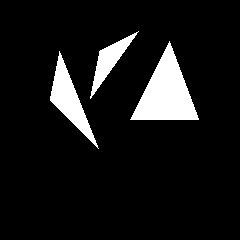

In [3]:
im = Image.new('RGB', im_size)
tri0 = triangle_2d((60,50),(50,100),(100,150))
tri1 = triangle_2d((100,50),(90,100),(140,30))
tri2 = triangle_2d((130,120),(200,120),(170,40))
tri0.render(im)
tri1.render(im)
tri2.render(im)
#tring.renderPoints(im)
im

In [4]:
cube = loadObj('3d_models/cube.obj',pos=(0,0,2))
j = 0
i = 0
start_time = time.time()
render_time = 0
font = ImageFont.truetype('Roboto-Black.ttf')


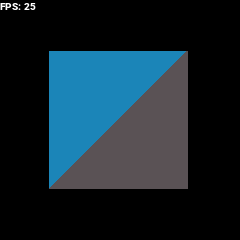

In [6]:

for j in range(360):
    i += 1
    im = Image.new('RGB', im_size)
    draw = ImageDraw.Draw(im)
    clear_output(wait=True)
    cube.ang = (i,j)
    start_time = time.time()
    cube.render(im)
    render_time = time.time()-start_time
    draw.text((0,0),"FPS: "+str(int(1/render_time)),font=font)
    display(im)

In [43]:
class plant():
    def __init__(self):
        self.size = 0
        self.leafs = []
        self.trunks = [[-0.15]]
        self.plant3DModel = None
        self.growCount = 0
        self.maxgrowCount = 30
        self.lastThreeLeafAngles = []
        
    def grow(self):
        if self.growCount < self.maxgrowCount:
            self.size += 0.05
            self.growCount += 1
            self.trunks[-1][0] += 0.05
            if self.growCount%3 == 0:
                print("new trunk")
                self.trunks.append([self.trunks[-1][0]])
            
    def addLeaf(self):
        angleChoices = [0,90,180,270,315]
        if self.growCount > 3 and self.growCount < self.maxgrowCount:
            for i in range(len(self.leafs)):
                l = self.leafs[i]
                l[0] = l[0] + 1
                if l[0] > 2:
                    l[0] = 2
            rot = random.choice(angleChoices)
            while rot in self.lastThreeLeafAngles:
                rot = random.choice(angleChoices)
            self.lastThreeLeafAngles.append(rot)
            if len(self.lastThreeLeafAngles) > 2:
                self.lastThreeLeafAngles = self.lastThreeLeafAngles[-3:]
            self.leafs.append([0,self.size,rot])
    
    def generateModel(self):
        self.plant3DModel = multipart_model()
        base = loadObj('3d_models/base.obj')
        base.setColorPallet([(86,53,23)]) 
        self.plant3DModel.addModel(base)
        for l in self.leafs:
            leaf = None
            if l[0] == 0:
                leaf = loadObj('3d_models/leaf2_tiny.obj')
            if l[0] == 1:
                leaf = loadObj('3d_models/leaf2_small.obj')
            if l[0] == 2:
                leaf = loadObj('3d_models/leaf2.obj')                
            leaf.setColorPallet([(74,103,65)]) 
            leaf.pos = (0,l[1],0)
            leaf.ang = (0,l[2])
            self.plant3DModel.addModel(leaf)

        for t in self.trunks:
            trunk = loadObj('3d_models/trunk.obj')
            trunk.setColorPallet([(97,126,48)]) 
            trunk.pos = (0,t[0],0)
            self.plant3DModel.addModel(trunk)
        
        self.plant3DModel.pos = (0,2,2)
        self.plant3DModel.ang = (180,0)

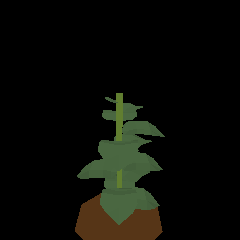

In [46]:
newPlant = plant()
newPlant.generateModel()
i = 180
for j in range(3600*2):
    newPlant.generateModel()
    clear_output(wait=True)
    im = Image.new('RGB', im_size)
    newPlant.plant3DModel.ang = (i,j)
    newPlant.plant3DModel.render(im,cam_ang=(20,0))
    display(im)
    if j%180 == 0:
        newPlant.grow()
    if j%360 == 0:
        newPlant.addLeaf()


In [683]:
newPlant.lastThreeLeafAngles

[180, 0, 270]

In [693]:
"1234"[-3:]

'234'